# Image Captioning using TensorFlow 2 ,InceptionNet_v3 & LSTM

### Initialize GPU

In [20]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Import Libraries

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.utils import np_utils
import random
from tensorflow.keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

### Load Data 

In [22]:
images_dir = os.listdir(r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Images')

images_path = r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Images'
captions_path = r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt"
train_path = r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt"
val_path =r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.devImages.txt"
test_path = r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [23]:
len(x_val)

1001

### Loading captions as values and images as key in dictionary

In [24]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

### Displaying an image and captions given to it

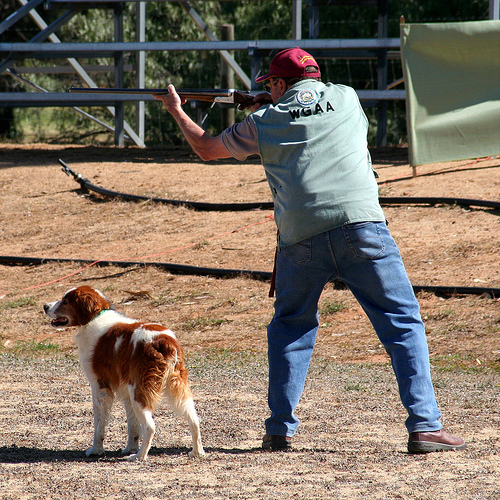

A man , a gun , and a dog .
A man aiming a rifle with a dog standing beside him .
A man shoots a rifle while a dog looks on .
Man aiming a rifle with his dog at his side .
The man is aiming to shoot something while his dog watches .


In [25]:
temp = captions[1800].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+"\\"+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

### Creating train, test and validation dataset files with header as 'image_id' and 'captions'

In [26]:
train_dataset = open(r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open(r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open(r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

### populating the above created files for train , test and validation dataset with image ids and captions for each of these images

In [27]:
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [28]:
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = InceptionV3(include_top=False,weights='imagenet',input_shape=(299,299,3),pooling='avg')
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [29]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(299,299,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [30]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(299,299,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [32]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path +"\\"+ ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [33]:
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [53]:
# opening train_encoded_images.p file and dumping it's content
with open(r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [35]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv(r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [36]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [37]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [38]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [39]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [40]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [41]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [42]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

In [43]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [44]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

4644
soda
2170
fell


In [45]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [46]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [47]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [48]:
print(padded_sequences[0])

[[4644    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4644 8107    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4644 8107 4085    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4644 8107 4085  947    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4644 8107 4085  947 3415    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [49]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [50]:
num_of_images = 2000

In [51]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [52]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [67]:
with open(r'D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")
encoded_images.keys()

dict_keys(['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117_b4543e1460.jpg', '6971

In [75]:
imgs = []

for ix in range(ds.shape[0]):
     if ds[ix, 0] in encoded_images.keys():
          
        #print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs)

[[ 0.7478418   1.5915923   0.169763   ...  0.          0.
   0.        ]
 [ 0.7478418   1.5915923   0.169763   ...  0.          0.
   0.        ]
 [ 0.7478418   1.5915923   0.169763   ...  0.          0.
   0.        ]
 ...
 [11.704041    1.5861658   5.7549276  ...  0.24238196  0.
   1.1362326 ]
 [11.704041    1.5861658   5.7549276  ...  0.24238196  0.
   1.1362326 ]
 [11.704041    1.5861658   5.7549276  ...  0.24238196  0.
   1.1362326 ]]


In [76]:
imgs.shape

(15000, 2048)

In [77]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [78]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [79]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [80]:
images = np.load("images.npy")

print(images.shape)

(25493, 2048)


In [81]:
embedding_size = 128
max_len = 40

In [82]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [83]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [84]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
______________________________________________________________________________________________

In [85]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

50/50 [==============================] - 127s 3s/step - loss: 4.8005 - accuracy: 0.1298
Epoch 13/200
50/50 [==============================] - 228s 5s/step - loss: 4.7033 - accuracy: 0.1507
Epoch 14/200
50/50 [==============================] - 14s 286ms/step - loss: 4.5751 - accuracy: 0.1793
Epoch 15/200
50/50 [==============================] - 21s 422ms/step - loss: 4.4513 - accuracy: 0.2014
Epoch 16/200
50/50 [==============================] - 82s 2s/step - loss: 4.3333 - accuracy: 0.2185
Epoch 17/200
50/50 [==============================] - 113s 2s/step - loss: 4.2529 - accuracy: 0.2273
Epoch 18/200
50/50 [==============================] - 121s 2s/step - loss: 4.2027 - accuracy: 0.2304
Epoch 19/200
50/50 [==============================] - 5368s 107s/step - loss: 4.1228 - accuracy: 0.2376
Epoch 20/200
50/50 [==============================] - 17s 337ms/step - loss: 4.1846 - accuracy: 0.2341
Epoch 21/200
50/50 [==============================] - 18s 351ms/step - loss: 4.1138 - accuracy: 

In [86]:
model.save_weights(r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\model_weights.h5")

In [87]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(299,299,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [88]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [89]:
inceptionNet = InceptionV3(include_top=False,weights='imagenet',input_shape=(299,299,3),pooling='avg')

In [131]:
img = r"D:\Image_Captioning\archive(7)\Flickr_Data\Flickr_Data\Images\236518934_c62a133077.jpg"

test_img = get_encoding(inceptionNet, img)

In [132]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

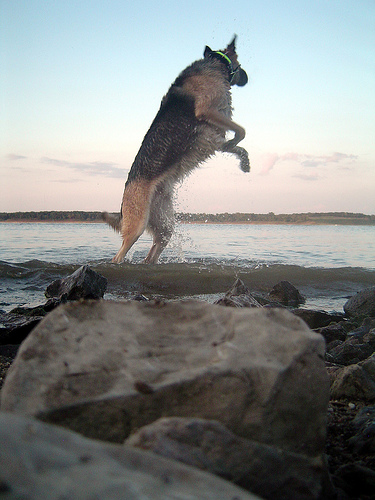

A dog is jumping through some water on rocks on the foreground .


In [133]:
z = Image(filename=img)
display(z)

print(Argmax_Search)